Script to combine JSON simulation result files into a unified results structure.

Each input file must follow the naming convention:
    `{name}_sim{sim_id}_{timestamp}.json`

and contain a JSON object with keys:
- scenario_name: str
- sim_id: int
- agent_names: list of str
- cum_regrets: list of lists (one per agent)
- time_agents: list of lists (one per agent)

The script aggregates data across multiple files for the same scenario and sim_id,
producing a `results` dict:

```
results[scenario_name] = {
    "scenario_name": scenario_name,
    "sim_id": [list of sim_ids],
    "regrets": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
    "times": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
}
```

## Pre

In [1]:
import os
import glob
import json
import numpy as np

def load_and_combine(json_dir: str = '.'):
    # Temporary storage: scenario -> sim_id -> list of file data dicts
    files_data = {}

    # Collect and parse all JSON files
    for filepath in glob.glob(os.path.join(json_dir, '*.json')):
        with open(filepath, 'r') as f:
            data = json.load(f)
        scenario = data['scenario_name']
        sim_id = data['sim_id']
        # filter out 'Random' agent except for the first time
        rnd_idx = data['agent_names'].index('Random') if 'Random' in data['agent_names'] else None
        if rnd_idx is not None:
            # if this sim_id already has a 'Random' agent, remove it
            for existing_entry in files_data.get(scenario, {}).get(sim_id, []):
                if 'Random' in existing_entry['agent_names']:
                    data['agent_names'].pop(rnd_idx)
                    data['cum_regrets'] = np.delete(data['cum_regrets'], rnd_idx, axis=1).tolist()
                    data['time_agents'] = np.delete(data['time_agents'], rnd_idx, axis=1).tolist()
                    break
        files_data.setdefault(scenario, {}).setdefault(sim_id, []).append({
            'agent_names': data['agent_names'],
            'cum_regrets': data['cum_regrets'],
            'time_agents': data['time_agents'],
        })

    results = {}
    # Combine per scenario
    for scenario_name, sim_dict in files_data.items():
        # Determine all unique agent names
        all_agents = sorted({name for entries in sim_dict.values() for e in entries for name in e['agent_names']})

        # Simulation IDs sorted
        sim_ids = sorted(sim_dict.keys())
        n_simulations = max(sim_ids) + 1
        # Determine number of draws from the first entry
        sample = sim_dict[sim_ids[0]][0]
        n_draws = len(sample['cum_regrets'])

        # Allocate arrays for each agent
        all_regrets = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}
        all_times   = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}

        # Fill arrays with transposed data (draws × agents -> agents × draws)
        for sim_id, entries in sim_dict.items():
            for entry in entries:
                cum_regs = np.array(entry['cum_regrets'])   # shape: (n_draws, n_agents)
                time_ag  = np.array(entry['time_agents'])   # shape: (n_draws, n_agents)
                for i, name in enumerate(entry['agent_names']):
                    all_regrets[name][sim_id, :] = cum_regs[:, i]
                    all_times[name][sim_id, :]   = time_ag[:, i]

        # Build scenario's combined results
        results[scenario_name] = {
            'scenario_name': scenario_name,
            'sim_id': sim_ids,
            'regrets': all_regrets,
            'times': all_times,
        }

    return results

In [2]:
combined = load_and_combine('./results/compare_all')

In [3]:
from compare_agents import *

# print_summary_results(combined)

In [4]:
combined = {k: combined[k] for k in [
    # "Linear",
    # "Friedman",
    # "LinFriedman",
    # "Friedman2",
    # "Friedman3",
    "Magic",
    "Shuttle",
    "Adult",
    "Mushroom",
    # "Iris",
    # "Wine",
    # "Heart"
    ] if k in combined}

## Printed Info

In [5]:
print_topn_agents_per_scenario(combined, 5)


Top 5 agents per scenario:
                         Magic                   Adult             Mushroom
Rank 1  RefreshBARTm_dirichlet               XGBoostTS  RefreshBARTm_tree2x
Rank 2     RefreshBARTm_tree2x     RefreshBARTm_tree2x         RefreshBARTm
Rank 3            RefreshBARTm  RefreshBARTm_dirichlet         BARTm_tree2x
Rank 4               XGBoostTS            RefreshBARTm                 RFTS
Rank 5                    RFTS  RefreshBARTo_dirichlet                BARTm


In [6]:
print_pairwise_win_tie_lose(combined)


Totals across all scenarios (sorted by win*3+tie):
                        win  tie  lose
RefreshBARTm_tree2x      32   28     0
RefreshBARTm             29   31     0
XGBoostTS                28   29     3
RefreshBARTm_dirichlet   28   27     5
RFTS                     22   34     4
RefreshBARTo             14   36    10
BARTm_tree2x             14   35    11
BARTm                    12   37    11
RefreshBARTo_dirichlet   12   35    13
BARTm_dirichlet          12   32    16
RefreshBARTo_tree2x       8   34    18
BARTo_dirichlet           5   41    14
BARTo                     5   36    19
BARTo_tree2x              5   33    22
LinearTS                  3   19    38
Random                    0   15    45


In [7]:
print_relative_performance(combined)


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
RefreshBARTm_tree2x          0.236    0.222    0.384
RefreshBARTm                 0.240    0.223    0.386
RFTS                         0.267    0.226    0.391
BARTm_tree2x                 0.272    0.247    0.428
BARTm                        0.309    0.240    0.416
XGBoostTS                    0.314    0.208    0.361
BARTm_dirichlet              0.350    0.231    0.400
RefreshBARTm_dirichlet       0.354    0.198    0.343
RefreshBARTo_dirichlet       0.469    0.179    0.310
RefreshBARTo                 0.480    0.182    0.316
BARTo_dirichlet              0.556    0.173    0.300
RefreshBARTo_tree2x          0.585    0.172    0.298
BARTo_tree2x                 0.602    0.179    0.309
BARTo                        0.636    0.148    0.256
LinearTS                     1.000    0.000    0.000
Random                       3.106    1.66

In [8]:
print_relative_performance(combined, "times")


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
Random                       0.148    0.010    0.017
LinearTS                     1.671    0.042    0.073
BARTo                      105.384   49.596   85.903
XGBoostTS                  112.661    7.228   12.520
BARTm                      132.675  172.091  298.070
BARTo_dirichlet            133.096  615.798 1066.593
BARTm_dirichlet            134.622  157.388  272.605
RFTS                       145.805   17.210   29.808
BARTo_tree2x               185.064   31.185   54.014
BARTm_tree2x               227.645  132.641  229.741
RefreshBARTo               243.803    7.411   12.836
RefreshBARTm               265.695   13.644   23.632
RefreshBARTo_dirichlet     297.727   15.477   26.807
RefreshBARTm_dirichlet     312.444   17.044   29.520
RefreshBARTo_tree2x        477.433    4.214    7.298
RefreshBARTm_tree2x        515.471   15.01

## Plot & Print

In [9]:
plot_print_total_regret_factors(combined)


Mean relative regret by "Model" category (rows) and scenario (columns):
                m        o
Adult    1702.625 1847.250
Average     0.006    0.007
Magic    1827.938 1717.188
Mushroom   68.812  218.875

Mean relative regret by "Tree" category (rows) and scenario (columns):
               1x       2x
Adult    1749.562 1800.312
Average     0.006    0.006
Magic    1768.188 1776.938
Mushroom  153.875  133.812

Mean relative regret by "Iter" category (rows) and scenario (columns):
Empty DataFrame
Columns: []
Index: []

Mean relative regret by "MC" category (rows) and scenario (columns):
Empty DataFrame
Columns: []
Index: []


## "Beautiful" Plots

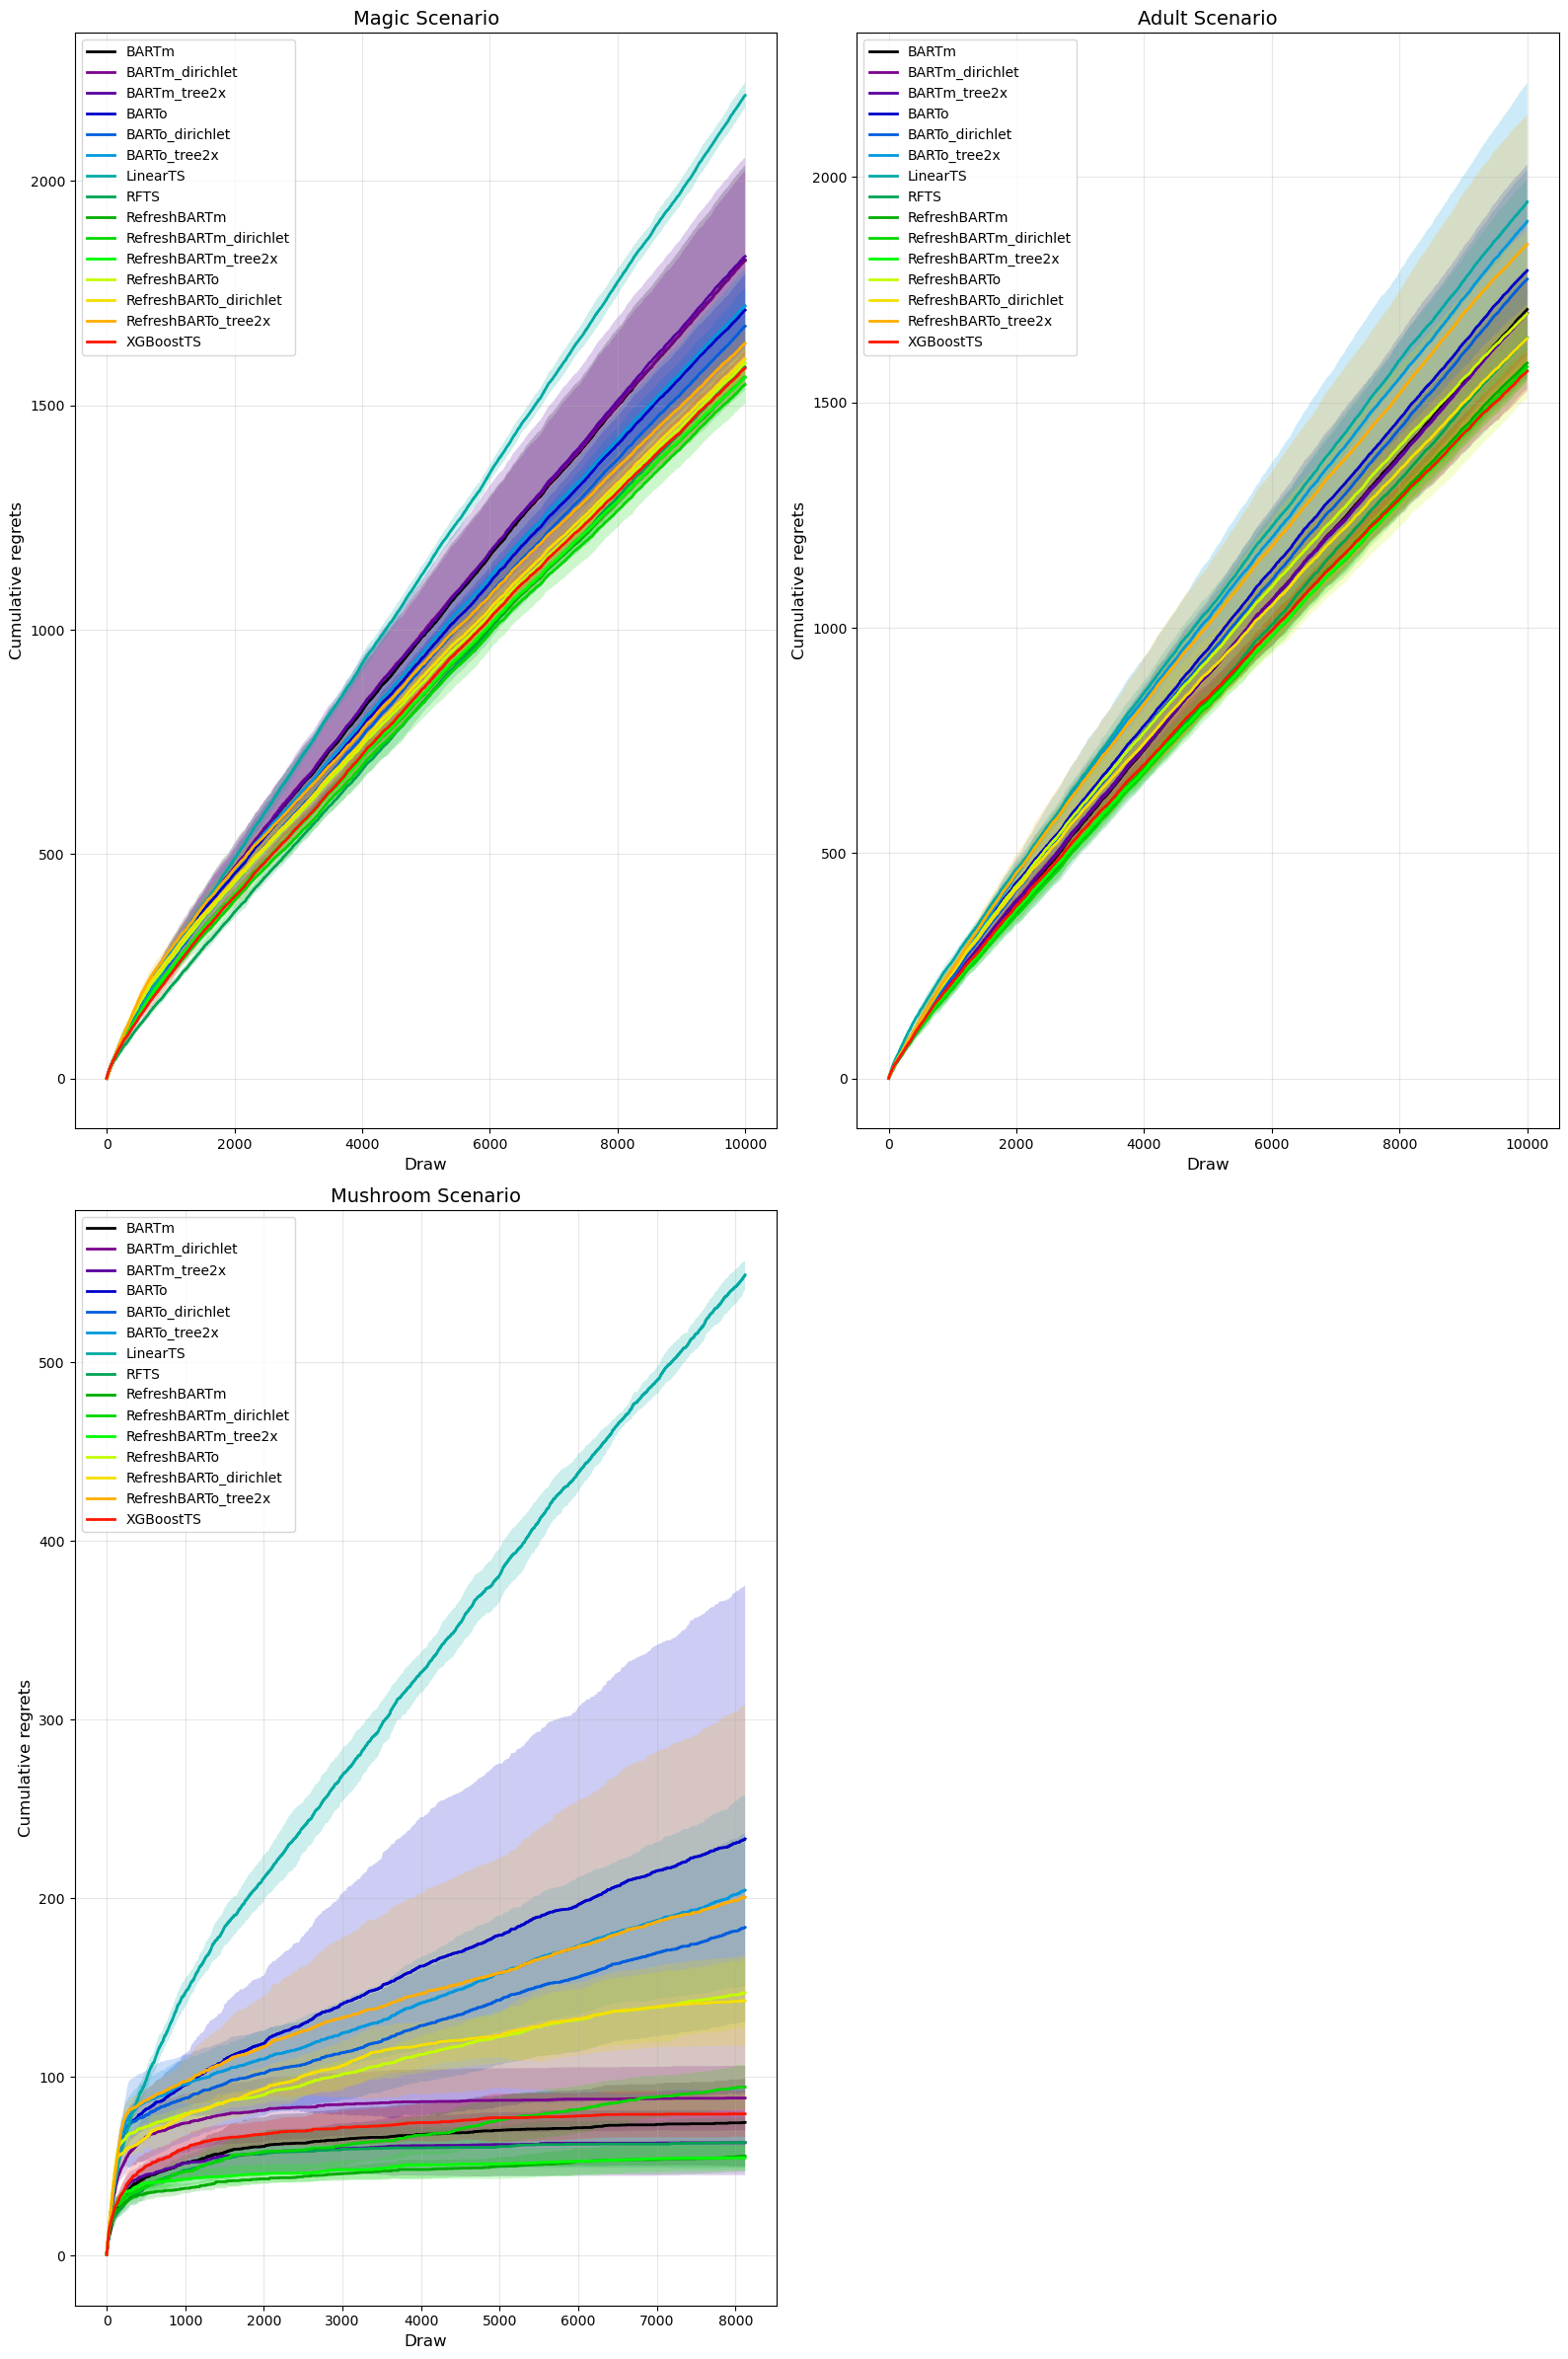

In [10]:
plot_comparison_results(combined, show_random=False)

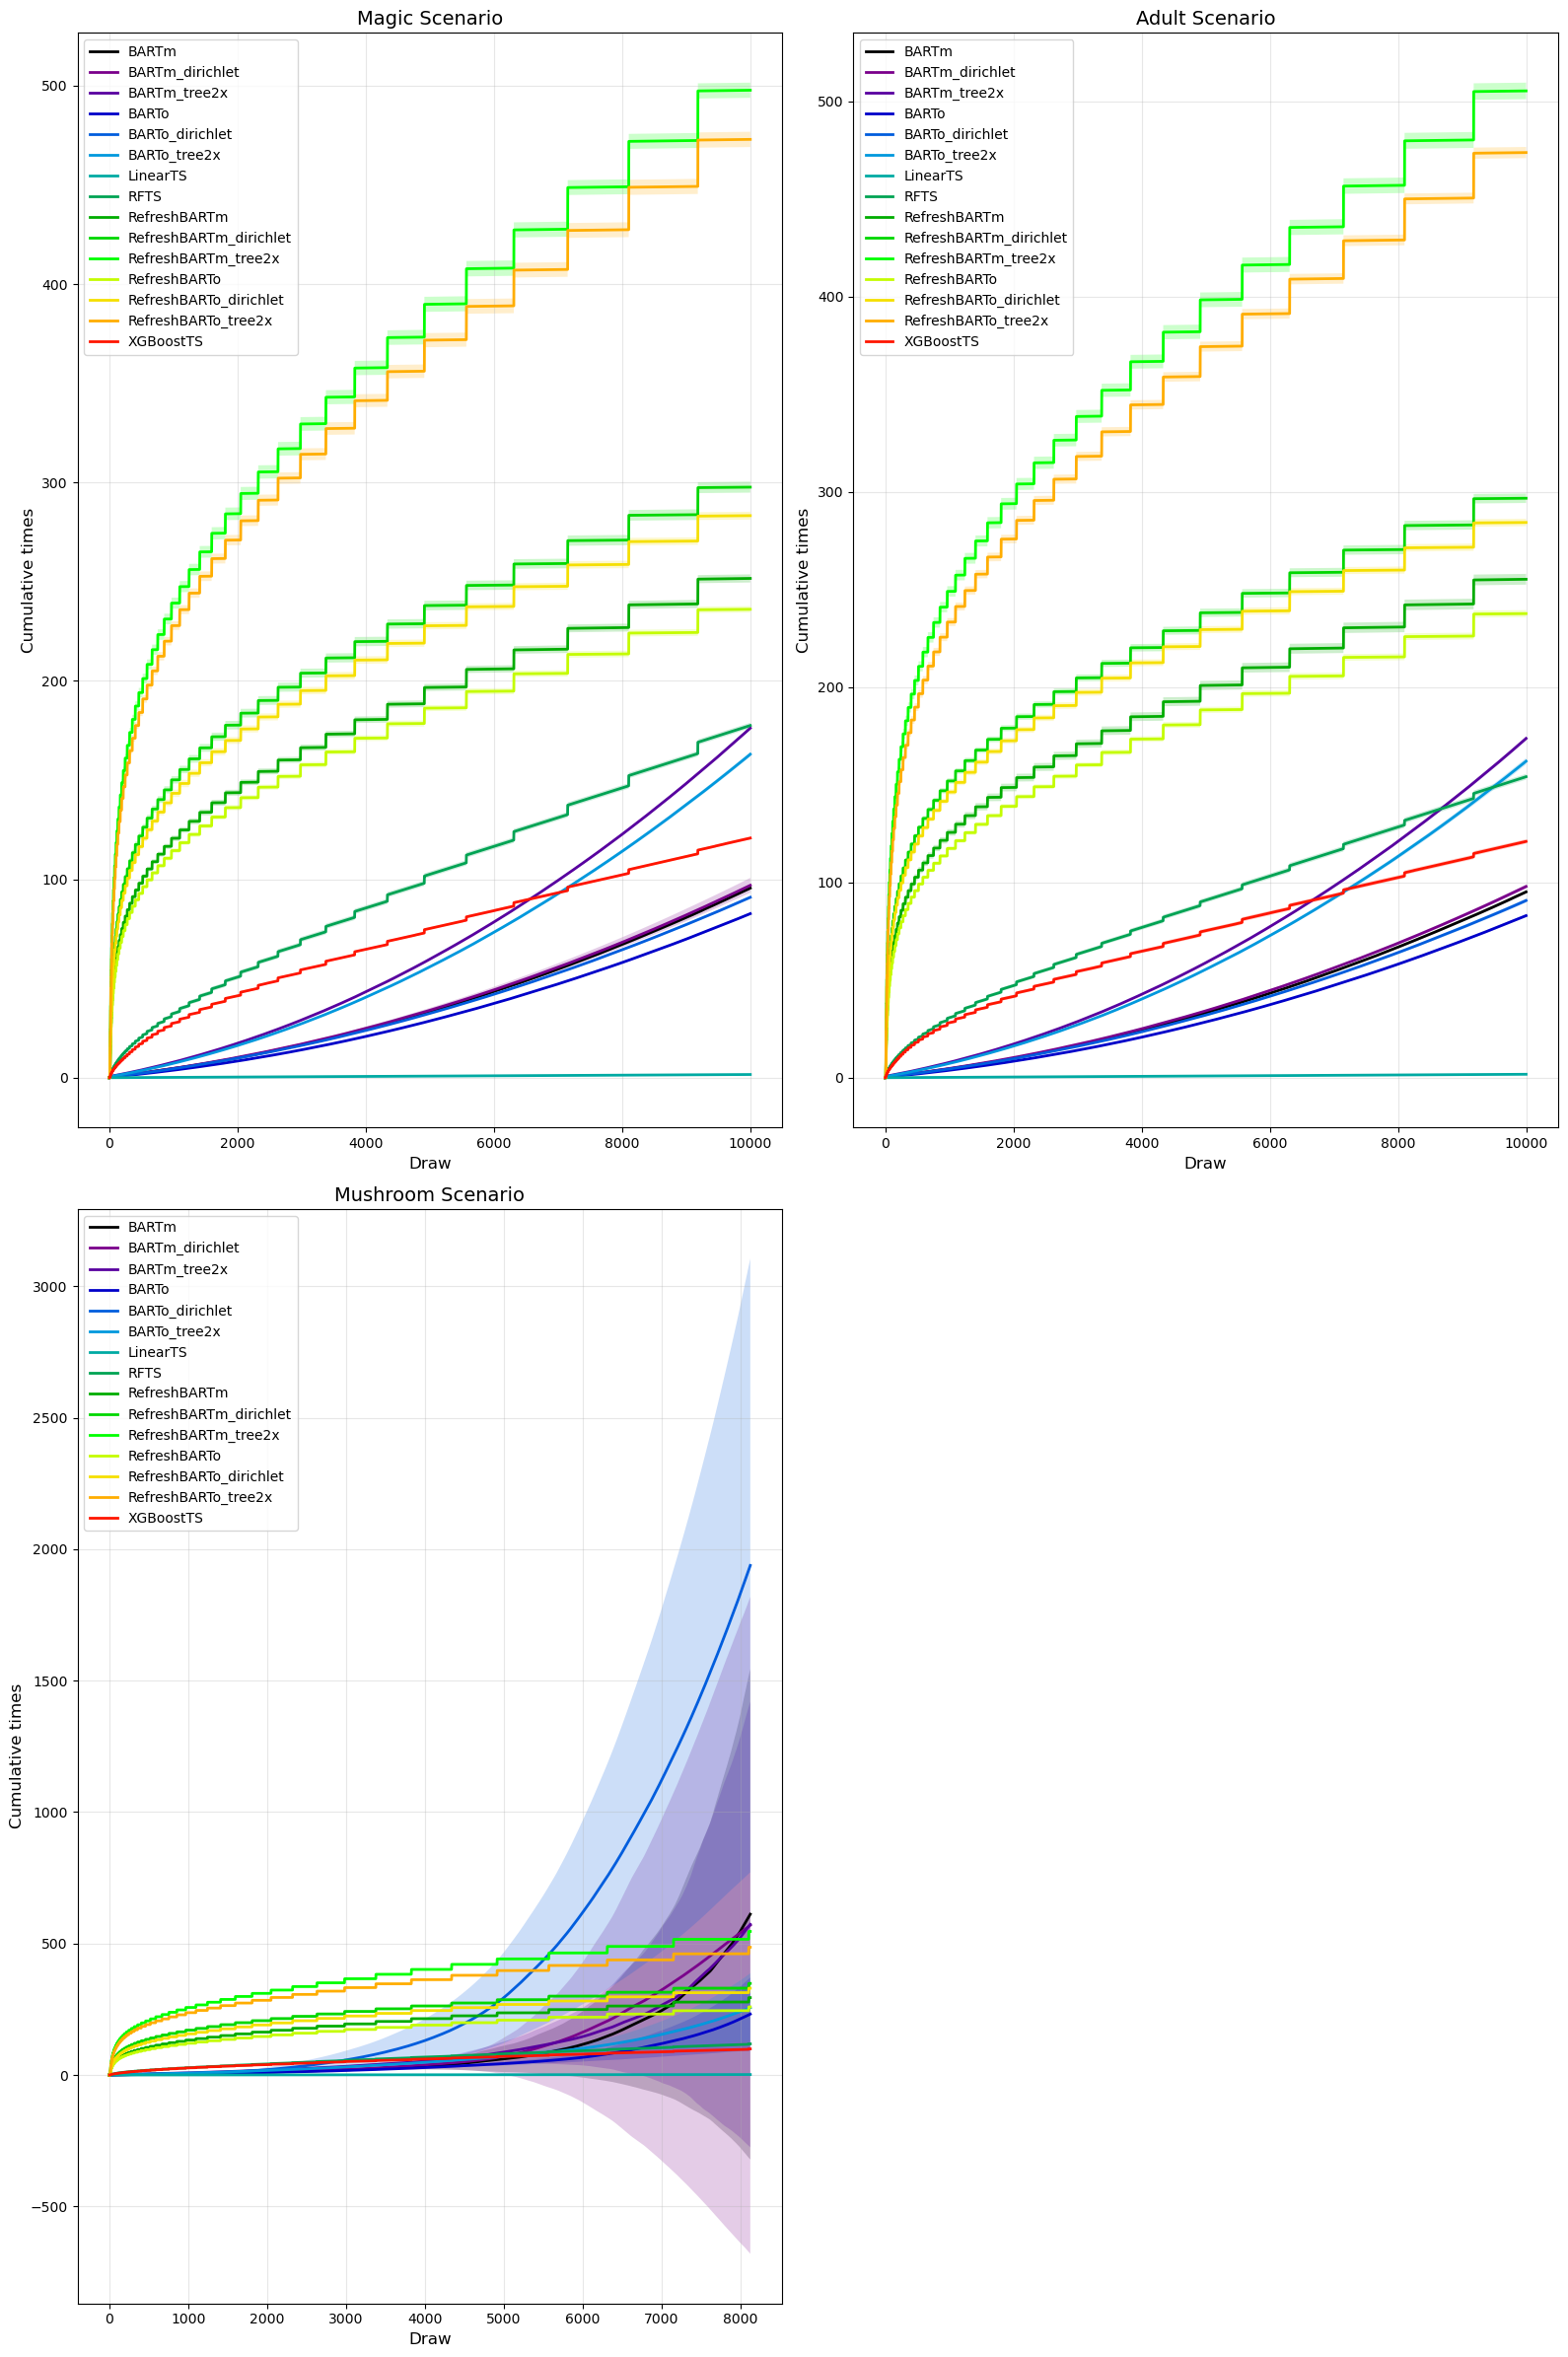

In [11]:
plot_comparison_results(combined, show_random=False, target="times")